- Load CESM2-WACCM model output over historical period
    - Variables: emiso2, emidms, mmrso4
    - Observations will come from mmrso4, goal is to constrain emissions
- Conduct Perfect Model experiments: withhold 1 year from the Prior and reconstruct it by drawing pseudo-observations


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import xesmf as xe

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean as cmo
import seaborn as sns

import copy
from glob import glob
import pickle

from time import time
import random

# Load Prior: CESM2-WACCM 
- histSST simulation

In [25]:
dpath = '../data/'
model_select = 'CESM2-WACCM_histSST'

In [52]:
def load_prior(year1, yearf, var_in, model_in, latslice_in=None):
    """
    year1: first year of model output to load
    yearf: final year of model output to load
    var_in: example, mmrso4
    latslice: optional limit domain, example latslice=slice(-30,30) for tropics
    """
    
    lpath = '../data/' + model_in + '/' + var_in

    ## specify files for looping; this will need to be looped later
    globpath_in = [glob(lpath + '*_' + str(yi) + '*.nc')[0] 
                   for yi in np.arange(year1, yearf, 1) 
                   if glob(lpath + '*_' + str(yi) + '*.nc')]

    ds_in = xr.open_dataset(globpath_in[0])[[var_in]]
    if var_in == 'mmrso4':
        ds_in = ds_in.isel(lev=-1) ## only get surface level

    ## if multiple files needed to span the time range, then concat them
    if len(globpath_in) > 1:
        for l,gpath in enumerate(globpath_in[1:]):
            temp = xr.open_dataset(gpath)[[var_in]]
            if var_in == 'mmrso4':
                temp = temp.isel(lev=-1)
            ds_in = xr.concat([ds_in, temp], dim='time', coords='minimal', compat='override')
       
    if latslice_in:
        ds_in = ds_in.sel(lat=latslice_in)
    
    return(ds_in[var_in])

In [53]:
latslice = slice(40, 60)
mmrso4 = load_prior(1850, 1900, 'mmrso4', model_select, latslice)
emiso2 = load_prior(1850, 1900, 'emiso2', model_select, latslice)
# emidms = load_prior(1850, 1900, 'emidms', model_select)

In [54]:
## Stack state variables into a vector
mmrso4_stack = mmrso4.stack(latlon=['lat','lon'])
size_mmrso4 = mmrso4_stack.latlon.size

emiso2_stack = emiso2.stack(latlon=['lat','lon'])
size_emiso2 = emiso2_stack.latlon.size

## Form state vector and combine state variables

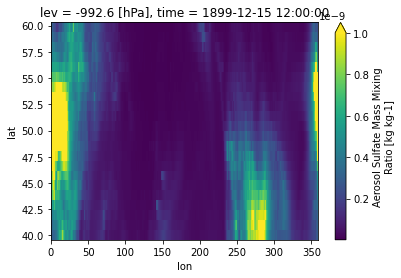

In [55]:
## assumes mmrso4 will always be in the prior, so this is the foundation
prior_stack = mmrso4_stack

## can only do this if 1 variable in the prior
prior_stack.isel(time=-1).unstack().plot(vmax=1e-9)
plt.show()

In [56]:
## Options to add variables to the state
include_emiso2 = True

if include_emiso2 == True:
    prior_stack = xr.concat([prior_stack, emiso2_stack], 
                            dim='latlon', coords='minimal')
    ## now there are 2 variables in here
    ## careful not to run this cell multiple times, otherwise it will keep concatting
    prior_stack

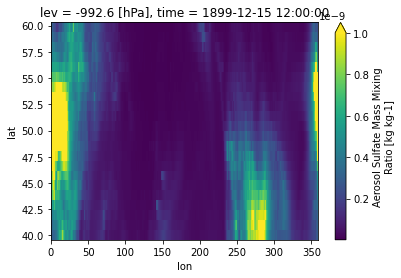

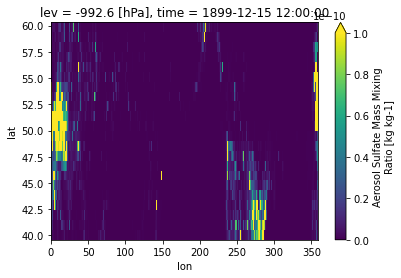

In [64]:
## Illustrate unstack method of recovering state variables
prior_stack.isel(time=-1, 
                     latlon=slice(0,size_mmrso4)).unstack().plot(vmax=1e-9)
plt.show()

## Illustrate unstack method of recovering state variables
prior_stack.isel(time=-1, 
                     latlon=slice(size_mmrso4, 
                                  size_mmrso4 + size_emiso2)).unstack().plot(vmax=1e-10)
plt.show()

# Choose target year and remove from prior

In [131]:
## CAREFUL! month will NOT be zero-indexed
## so 1 = january, 12 = december
target_month = 1
target_year = 1877

## set final prior here, then remove target from it
final_prior = prior_stack
target_stack = final_prior.sel(
    time=str(target_year) + '-' + str(target_month).zfill(2)).squeeze()

## only include the target month in prior
final_prior = final_prior.where(final_prior.time.dt.month == target_month, drop=True)

## remove actual target year from prior
final_prior = final_prior.where(final_prior.time.dt.year != target_year, drop=True)

In [159]:
## Size of prior ensemble
Nens = len(final_prior.time)
print(Nens)

## specify observation error
## NEED SOMETHING MORE PLAUSIBLE HERE
R_obserr = (1e-10)**2 ## K^2 (units should be variance, example Kelvin^2 for SST)

49


## Optional: convert prior to anomaly space

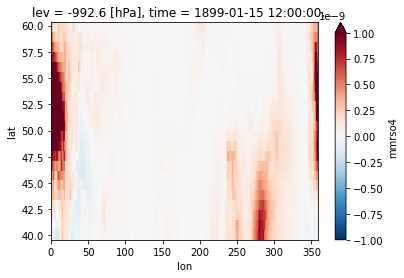

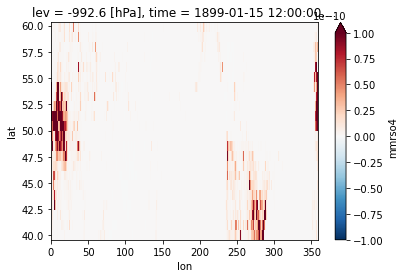

In [160]:
## I think we want to do the DA in anomaly space, but we can think about it
prior_stack_climo = final_prior.groupby('time.month').mean(dim='time')
final_prior_anom = final_prior.groupby('time.month') - prior_stack_climo

## Illustrate unstack method of recovering state variables
final_prior_anom.isel(time=-1, 
                     latlon=slice(0,size_mmrso4)).unstack().plot(vmax=1e-9)
plt.show()

## Illustrate unstack method of recovering state variables
final_prior_anom.isel(time=-1, 
                     latlon=slice(size_mmrso4, 
                                  size_mmrso4 + size_emiso2)).unstack().plot(vmax=1e-10)
plt.show()

## Prep observation network

In [161]:
## Method 1 ##
## random selection of lats and lons
obsel_method = 1 ## useless for now, but can switch methods later
nobs = 50

## get index of all nonzero values
## ONLY include mmrso4 as possible observations
index_nonzero = np.nonzero(target_stack.isel(latlon=slice(0, size_mmrso4)).values)[0]
index_nonzero

## get random index of obs
obs_ind = np.random.choice(index_nonzero, size=nobs, replace=False)
obs_actual = target_stack[obs_ind]

## add noise to observations
obs = obs_actual + np.sqrt(R_obserr)*np.random.randn(nobs)

## make obs error variance vector
R = R_obserr * np.ones(nobs)

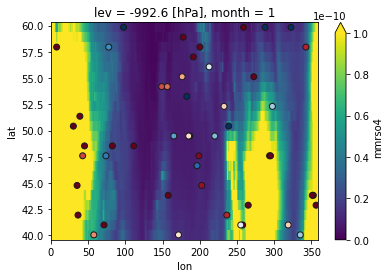

In [162]:
vabs = 1e-10
cmap = 'RdBu_r'

## standard deviation in prior
final_prior_anom.isel(latlon=slice(0,size_mmrso4)).std(
    dim='time').unstack().plot(vmin = 0, vmax=vabs, cmap='viridis')

## anomaly observations
plt.scatter(obs.lon, obs.lat, c=obs, 
            edgecolor='0.1', vmin = -vabs, vmax=vabs, cmap=cmap)

plt.show()

# Data assimilation

In [163]:
## estimate of data from prior (all observations)
Ye = final_prior_anom[:,obs_ind]


In [164]:
## FOR REFERENCE BUT not up to date
## Whitaker and Hamill (2002), ensemble square-root filter

# Inputs: 
#     Xprior_in: prior ensemble state vector (Nens x Nstatevars)
#     obs: observations (may be perturbed) (Nobs)
#     Ye: estimates of obs from prior (vector Nobs)
#     R_obserr: Error variance of observations (vector Nobs)
#     loc: localization vector (vector Nstatevar)

Xprior_in = final_prior_anom

## length of original state vector
nx = Xprior_in.shape[1]
print(nx)

## augment state vector with Ye appended
## this could be avoided if all obs are a direct subset of state vector
## but this method simplifies code and calcs
Xprior = xr.concat([Xprior_in, Ye], dim='latlon')
print(Xprior.shape, '(ens, state + appended obs)')


## Specify Localization radius
loc = None
locR = 12000 #km

12672
(49, 12722) (ens, state + appended obs)


In [179]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = list(map(np.radians, [lon1, lat1, lon2, lat2]))
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367.0 * c
    
    return(km)

def cov_localization(locRad, obvalue, Xprior_input):
    """

    Originator: R. Tardif, 
                Dept. Atmos. Sciences, Univ. of Washington
                
         Edits: V. Cooper (abbreviated version)
    -----------------------------------------------------------------
     Inputs:
        locRad : Localization radius (distance in km beyond which cov are forced to zero)
       obvalue : Observation, needed to get ob site lat/lon (to calculate distances w.r.t. grid pts)
             X : Prior object, needed to get state vector info. 

     Output:
        covLoc : Localization vector (weights) applied to ensemble covariance estimates.
                 Dims = (Nstate) length of the state vector.

     Note: Uses the Gaspari-Cohn localization function.

    """

    ## declare the localization array, filled with ones to start with (as in no localization)
    # stateVectDim, nbdimcoord = X_coords.shape

    covLoc = np.ones(Xprior_input.latlon.shape)
    # covLoc = np.ones(shape=[stateVectDim],dtype=np.float64)

    # Mask to identify elements of state vector that are "localizeable"
    # i.e. fields with (lat,lon)
    localizeable = covLoc == 1. # Initialize as True

    ## if variable is not a field with lats & lons, tag localizeable as False
    ##     if X.trunc_state_info[var]['spacecoords'] != ('lat', 'lon'):
    ##         localizeable[var_state_pos_begin:var_state_pos_end+1] = False

    ## array of distances between state vector elements & proxy site
    ## initialized as zeros: this is important!
    dists = np.zeros(shape=covLoc.shape)

    ## geographic location of observation
    site_lat = obvalue.latlon.item()[0]
    site_lon = obvalue.latlon.item()[1]
    ## geographic locations of elements of state vector
    X_lon = Xprior_input.lon
    X_lat = Xprior_input.lat

    ## calculate distances for elements tagged as "localizeable". 
    dists[localizeable] = np.array(haversine(site_lon, site_lat,
                                             X_lon[localizeable],
                                             X_lat[localizeable]))

    ## those not "localizeable" are assigned with a distance of "nan"
    ## so these elements will not be included in the indexing
    ## according to distances (see below)
    # dists[~localizeable] = np.nan

    ## Some transformation to variables used in calculating localization weights
    hlr = 0.5*locRad; # work with half the localization radius
    r = dists/hlr

    # indexing w.r.t. distances
    ind_inner = np.where(dists <= hlr)    # closest
    ind_outer = np.where(dists >  hlr)    # close
    ind_out   = np.where(dists >  2.*hlr) # out

    ## Gaspari-Cohn function
    ## for pts within 1/2 of localization radius
    covLoc[ind_inner] = (((-0.25*r[ind_inner]+0.5)*r[ind_inner]+0.625)* \
                         r[ind_inner]-(5.0/3.0))*(r[ind_inner]**2)+1.0
    ## for pts between 1/2 and one localization radius
    covLoc[ind_outer] = ((((r[ind_outer]/12. - 0.5) * r[ind_outer] + 0.625) * \
                          r[ind_outer] + 5.0/3.0) * r[ind_outer] - 5.0) * \
                          r[ind_outer] + 4.0 - 2.0/(3.0*r[ind_outer])
    ## Impose zero for pts outside of localization radius
    covLoc[ind_out] = 0.0

    ## prevent negative values: calc. above may produce tiny negative
    ## values for distances very near the localization radius
    ## TODO: revisit calculations to minimize round-off errors
    covLoc[covLoc < 0.0] = 0.0

    return(covLoc)

def EnSRF_serial(Xprior_input, obvalue, Ye_i, R_i,loc=None):
    """
    Perform update based on a single observation (unperturbed).
    Incremental changes by V. Cooper from G. Hakim and L. Madaus codebase.
    
    Xprior_input: Nens x Nstate(stacked), xarray
                  Note, this will be updated iteratively (final prior will become posterior)
         obvalue: Individual observation 
                  NEED TO CHECK whether this should have perturbations                  
            Ye_i: Nens (stacked), ensemble of individual observation
             R_i: Error for given observation
             loc: Nstate (stacked), localization vector [optional]
    
    "The EnSRF uses the traditional Kalman gain for updating the ensemble mean 
    but uses a 'reduced' Kalman gain to update deviations from the ensemble mean. 
    There is no additional computational cost incurred by the EnSRF relative to the 
    EnKF when the observations have independent errors and are processed one at a time."
    
    "If observation errors are correlated (𝗿 is not diagonal), the variables may be 
    transformed into the space in which 𝗿 is diagonal, or observations with correlated 
    errors may be processed in batches using Eq. (10)."
    
    (Whitaker & Hamill 2002)
    
    """
    Ye_i = Ye_i.rename({'time':'ens'}) ## using different times as ensemble members
    Xprior_input = Xprior_input.rename({'time':'ens'})
    
    ## ensemble size
    Nens = len(Xprior_input.ens)
    
    ## prior mean and perturbations
    ## recall that prior has Ye appended
    Xprior_m = np.nanmean(Xprior_input, axis=0)
    Xprior_pert = Xprior_input - Xprior_m

    ## mean and variance of proxy estimate
    Ye_m = Ye_i.mean(dim='ens')
    Ye_pert = Ye_i.values - Ye_m.values
    Ye_variance = Ye_i.var(dim='ens',ddof=1)
    
    ## Innovation
    innov = obvalue - Ye_m

    #### Kalman Gain
    ## numerator, model covariance with obs locations
    Kcov = np.dot(Xprior_pert.T, Ye_pert) / (Nens - 1)

    ## Option to localize the gain
    if loc is not None:
        Kcov = np.multiply(Kcov, loc)

    ## denominator, variance of innovation
    Kdenom = (Ye_variance + R_i)

    Kgain = np.divide(Kcov, Kdenom.values)
    
    ## update ensemble mean
    Xpost_m = Xprior_m + Kgain * innov.values
    
    ## update ensemble members using square root method (Whitaker & Hamill 2002)
    ## Note: if errors are correlated in R, this algorithm won't work
    ## (Will need to transform to space where R is diagnoal)
    ## Adjusted Kalman Gain
    alph  = 1/(1 + np.sqrt(R_i / (Kdenom)))
    Kgain = alph.values * Kgain ## adjusted Gain by constant alpha
    Xpost_pert = Xprior_pert - np.dot(Ye_pert[np.newaxis].T, Kgain[np.newaxis])
    
    ## Full posterior state (including all ensemble members, and Ye_posterior appended)
    Xpost = Xpost_m + Xpost_pert
    
    return(Xpost.rename({'ens':'time'}))

In [180]:
%%time 
## Perform serial update, looping over observations
X_iterate = Xprior ## initialize prior with Ye of obs appended

## option to save ensemble means for plotting
## copy shape from Xprior
X_post_save = (0*Xprior).rename(time='iob')[0]
X_post_save = xr.concat([X_post_save] * nobs, dim='iob')

## create random shuffling of obs order
iarr = np.arange(len(obs))
np.random.shuffle(iarr) ## shuffles order in place

CPU times: user 53.1 ms, sys: 55 µs, total: 53.1 ms
Wall time: 55.3 ms


In [182]:
for j, i in enumerate(iarr):
    obval = obs[i]
    ## localization
    if locR is not None:
        loc = cov_localization(locR,obval, X_iterate) 
    
    ## Update iterative prior, save as posterior
    Xpost = EnSRF_serial(X_iterate, obval, Ye[:,i], R[i], loc=loc)
    
    ## Update iterative prior for next loop
    X_iterate = Xpost
    
    ## save each loop for animation
    X_post_save[i] = Xpost.mean(dim='time')
    

## separately save final Ye_posterior in xarray for later validation
Ye_post = Ye - Ye + Xpost[:,len(Xprior_in[0]):]
## Note: Ye_post is also included at end of Xpost array

# convert posterior state to xarray, copying shape from prior;
# only include state (drop appended Ye)
Xpost_xr = Xprior_in - Xprior_in + Xpost[:,0:len(Xprior_in[0])]

In [189]:
(target - Xprior_in.mean(dim='time')).unstack()

<xarray.DataArray 'mmrso4' (lat: 22, lon: 288)>
array([[-3.31695852e-13, -7.33333343e-15, -7.98109612e-14, ...,
        -5.61326268e-13, -8.82478227e-14, -1.49661980e-13],
       [-2.01989264e-13, -3.24234563e-13, -3.54226956e-13, ...,
        -6.12832484e-13, -9.10688761e-14, -4.71521456e-14],
       [-1.08183909e-13, -1.63995133e-13, -6.44152104e-13, ...,
        -7.43701094e-14, -6.99167151e-14, -1.68954802e-13],
       ...,
       [-3.73377578e-14, -8.37690445e-14, -4.58784927e-14, ...,
         1.42624920e-12,  5.12368360e-13, -4.73658330e-13],
       [-2.98534018e-14, -9.58569026e-14, -7.95466191e-14, ...,
         4.29363224e-13,  1.65418298e-13, -9.82906858e-15],
       [-9.50893417e-15, -2.62010736e-14, -1.03436004e-13, ...,
         1.86554822e-14,  7.17082169e-14,  2.15039520e-13]], dtype=float32)
Coordinates:
    lev      float64 -992.6
    time     object 1877-01-15 12:00:00
    month    int64 1
  * lat      (lat) float64 40.05 40.99 41.94 42.88 ... 57.02 57.96 58.9 59.84
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

# Plot results

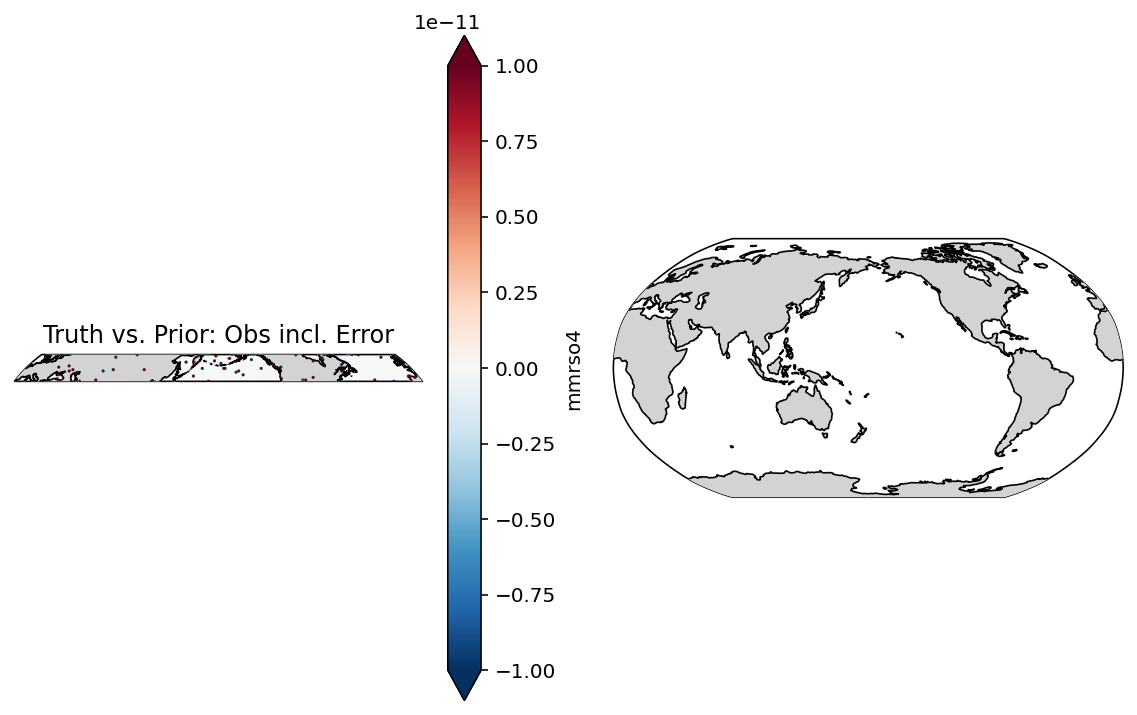

In [195]:
## Truth vs Prior and
## Posterior vs Prior
vabs = 1e-11
postplot = Xpost[:,0:size_mmrso4].unstack().mean(dim='time')
innovs = obs - Ye[:,0:nobs].mean(dim='time')
innovs_noerr = obs_pairs - Ye[:,0:nobs].mean(dim='time')

## Set up the figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=72*2,
                               subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
## initialize plot
# ax1.set_global()
# ax2.set_global()
ax1.set_extent([-180,180,40,60],crs=ccrs.PlateCarree())
ax1.coastlines(zorder=6,lw=0.8)
ax2.coastlines(zorder=6,lw=0.8)
ax1.add_feature(cfeature.LAND, facecolor='lightgray',zorder=5)
ax2.add_feature(cfeature.LAND, facecolor='lightgray',zorder=5)

######### Truth vs Prior
plt.sca(ax1)
p1 = plt.pcolormesh(target[0:size_mmrso4].unstack().lon, target[0:size_mmrso4].unstack().lat, (target - Xprior_in.mean(dim='time')).unstack(),
               cmap='RdBu_r',vmin=-vabs,vmax=vabs, transform=ccrs.PlateCarree())
plt.colorbar(p1, label='mmrso4', shrink=0.6, extend='both')

## plot obs seen by assimilation (with error)
plt.scatter(obs.lon, obs.lat, c=innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
            transform=ccrs.PlateCarree(), zorder=6)
## plot true location data (no error)
# plt.scatter(obs.lon, obs.lat, c=innovs_noerr, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
#             transform=ccrs.PlateCarree(), zorder=6)
plt.title('Truth vs. Prior: Obs incl. Error')


# ######### Posterior vs Prior
# plt.sca(ax2)
# p2 = plt.pcolormesh(target.lon, target.lat, postplot - Xprior_in.mean(dim='ens')[0:statevar1size].unstack(),
#                     cmap='RdBu_r',vmin=-vabs,vmax=vabs, transform=ccrs.PlateCarree())
# plt.colorbar(p2, label='$\Delta$SST', shrink=0.6,  extend='both')
# plt.scatter(obs.lon, obs.lat, c=innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
#             transform=ccrs.PlateCarree(), zorder=6)
# plt.title('Posterior vs. Prior: Obs incl. Error')


# plt.tight_layout()
# plt.show()


# ##################################
# ##################################
# ## TREFHT 
# ##################################
# ##################################
# ## Truth vs Prior and
# ## Posterior vs Prior
# vabs = 2
# postplot = Xpost[:,statevar1size:statevar1size + statevar2size].unstack().mean(dim='ens')
# targetplot = target_stack[statevar1size:statevar1size+statevar2size].unstack()
# innovs = obs - Ye[:,0:nobs].mean(dim='ens')
# innovs_noerr = obs_pairs - Ye[:,0:nobs].mean(dim='ens')
# if tref == True:
#     cru_innovs = cru_obs - Ye[:,nobs:nobs+cru_nobs].mean(dim='ens')
#     cru_innovs_noerr = cru_obs_pairs - Ye[:,nobs:nobs+cru_nobs].mean(dim='ens')

# ## Set up the figure and axes for plotting
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=72*3,
#                                subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
# ## initialize plot
# ax1.set_global()
# ax2.set_global()
# ax1.coastlines(zorder=6,lw=0.8)
# ax2.coastlines(zorder=6,lw=0.8)
# # ax1.add_feature(cfeature.LAND, facecolor='lightgray',zorder=5)
# # ax2.add_feature(cfeature.LAND, facecolor='lightgray',zorder=5)

# ######### Truth vs Prior
# plt.sca(ax1)
# p1 = plt.pcolormesh(target.lon, target.lat, 
#                     targetplot - Xprior_in.mean(dim='ens')[statevar1size:statevar1size+statevar2size].unstack(),
#                cmap='RdBu_r',vmin=-vabs,vmax=vabs, transform=ccrs.PlateCarree())
# plt.colorbar(p1, label='$\Delta$T', shrink=0.6, extend='both')

# ## plot obs seen by assimilation (with error)
# # plt.scatter(obs.lon, obs.lat, c=innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
# #             transform=ccrs.PlateCarree(), zorder=6)
# ## plot true location data (no error)
# plt.scatter(cru_obs.lon, cru_obs.lat, c=cru_innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
#             transform=ccrs.PlateCarree(), zorder=6)
# plt.title('Truth vs. Prior: Obs incl. Error')


# ######### Posterior vs Prior
# plt.sca(ax2)
# p2 = plt.pcolormesh(target.lon, target.lat, 
#                     postplot - Xprior_in.mean(dim='ens')[statevar1size:statevar1size+statevar2size].unstack(),
#                     cmap='RdBu_r',vmin=-vabs,vmax=vabs, transform=ccrs.PlateCarree())
# plt.colorbar(p2, label='$\Delta$T', shrink=0.6,  extend='both')
# # plt.scatter(obs.lon, obs.lat, c=innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
# #             transform=ccrs.PlateCarree(), zorder=6)
# plt.scatter(cru_obs.lon, cru_obs.lat, c=cru_innovs, cmap='RdBu_r', vmin=-vabs, vmax= vabs, s=2, edgecolor='k', lw=0.1,
#             transform=ccrs.PlateCarree(), zorder=6)
# plt.title('Posterior vs. Prior: Obs incl. Error')


plt.tight_layout()
plt.show()